In [2]:
from diffusers import StableDiffusionPipeline, UNet2DConditionModel, AutoencoderKL, PNDMScheduler
from transformers import T5EncoderModel, T5TokenizerFast
import torch
import os
import numpy as np
import librosa
from tqdm import tqdm
import soundfile as sf
import torchaudio
from IPython.display import Audio
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
model_path = "/blob/v-yuancwang/AudioEditing/Diffusion/checkpoint-30000"
vae = AutoencoderKL.from_pretrained(model_path, subfolder="vae")
unet = UNet2DConditionModel.from_pretrained(model_path, subfolder="unet")
tokenizer = T5TokenizerFast.from_pretrained(model_path, subfolder="tokenizer")
text_encoder = T5EncoderModel.from_pretrained(model_path, subfolder="text_encoder")

In [ ]:
torch_device = "cuda:0"
vae.to(torch_device)
text_encoder.to(torch_device)
unet.to(torch_device)
vae.requires_grad_(False)
unet.requires_grad_(False)
text_encoder.requires_grad_(False)

In [5]:
mel_src = np.load("/blob/v-yuancwang/audio_editing_data/inpainting/mel/a0TQiHhsJP8.npy")
mel_tgt = np.load("/blob/v-yuancwang/audio_editing_data/audioset96/mel/a0TQiHhsJP8.npy")
text = " Inpainting:Steel guitar, slide guitar"

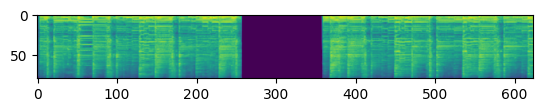

In [6]:
plt.imshow(mel_src)

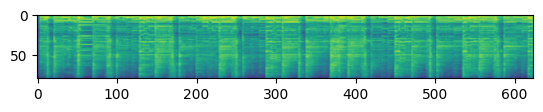

In [7]:
plt.imshow(mel_tgt)

In [8]:
prompt = [text]
text_input = tokenizer(prompt, max_length=tokenizer.model_max_length, truncation=True, padding="do_not_pad", return_tensors="pt")
text_embeddings = text_encoder(text_input.input_ids.to(torch_device))[0]
max_length = text_input.input_ids.shape[-1]
uncond_input = tokenizer(
    [""] * 1, padding="max_length", max_length=max_length, return_tensors="pt"
)
uncond_embeddings = text_encoder(uncond_input.input_ids.to(torch_device))[0] 
print(text_embeddings.shape)
print(uncond_embeddings.shape)
text_embeddings = torch.cat([uncond_embeddings, text_embeddings])

torch.Size([1, 13, 768])
torch.Size([1, 13, 768])


In [9]:
latents_src = torch.Tensor(np.array([[mel_src]])).to(torch_device)
latents_src = vae.encode(latents_src).latent_dist.sample()
print(latents_src.shape, latents_src.dtype, latents_src.device)

torch.Size([1, 4, 10, 78]) torch.float32 cuda:0


In [10]:
from diffusers import DDIMScheduler
num_inference_steps = 200
# scheduler = DDIMScheduler.from_pretrained(model_path, subfolder="scheduler")
scheduler = PNDMScheduler.from_pretrained(model_path, subfolder="scheduler")
scheduler.set_timesteps(num_inference_steps)

In [29]:
guidance_scale = 5

scheduler.set_timesteps(num_inference_steps)

latents = torch.randn((1, 4, 10, 78)).to(torch_device)
latents_src_input = torch.cat([latents_src] * 2)

for t in tqdm(scheduler.timesteps):
    # expand the latents if we are doing classifier-free guidance to avoid doing two forward passes.
    latent_model_input = torch.cat([latents] * 2)

    latent_model_input = scheduler.scale_model_input(latent_model_input, timestep=t)

    # predict the noise residual
    with torch.no_grad():
        noise_pred = unet(torch.cat((latent_model_input, latents_src_input), dim=1), t, encoder_hidden_states=text_embeddings).sample

    # perform guidance
    noise_pred_uncond, noise_pred_text = noise_pred.chunk(2)
    noise_pred = noise_pred_uncond + guidance_scale * (noise_pred_text - noise_pred_uncond)

    # compute the previous noisy sample x_t -> x_t-1
    latents = scheduler.step(noise_pred, t, latents).prev_sample

100%|██████████| 201/201 [00:11<00:00, 16.82it/s]


In [30]:
latents_out = latents_src + latents

In [31]:
with torch.no_grad():
    res = vae.decode(latents_out).sample
res = res.cpu().numpy()[0,0,:,:]

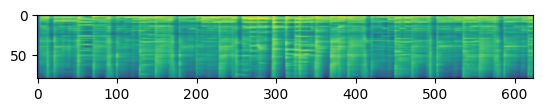

In [32]:
plt.imshow(res)

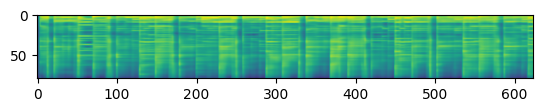

In [33]:
latents_tgt = torch.Tensor(np.array([[mel_tgt]])).to(torch_device)
latents_tgt = vae.encode(latents_tgt).latent_dist.sample()
with torch.no_grad():
    vae_res = vae.decode(latents_tgt).sample
vae_res = vae_res.cpu().numpy()[0,0,:,:]
plt.imshow(vae_res)

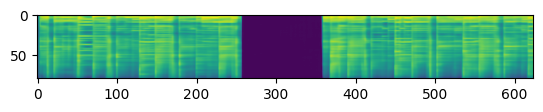

In [34]:
with torch.no_grad():
    vae_src_res = vae.decode(latents_src).sample
vae_src_res = vae_src_res.cpu().numpy()[0,0,:,:]
plt.imshow(vae_src_res)